## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
import string
from nltk.corpus import stopwords
from nltk import SnowballStemmer
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split


from keras.models import Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, SpatialDropout1D
from keras.optimizers import RMSprop

## Import Data, EDA and Preprocessing

**Unzip the dataset**

In [6]:
!unzip dataset.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


###**Loading the first dataset**

In [2]:
df1 = pd.read_csv('imbalanced_data.csv')
df1.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [4]:
# remove the id column
df1.drop(['id'], axis=1, inplace=True)

In [5]:
# check for null values
df1.isnull().sum()

label    0
tweet    0
dtype: int64

In [6]:
# check if any tweet bodies are null
df1['tweet'].isnull().values.any()

False

In [7]:
# check if there are empty tweet
(df1.tweet.str.len() == 0).any()

False

In [8]:
# check for duplicate
df1.duplicated().sum()

2432

In [9]:
## remove duplicates
df1.drop_duplicates(keep='first', inplace=True)

**check the label value counts**

In [10]:
df1.label.value_counts(normalize=True)

label
0    0.931832
1    0.068168
Name: proportion, dtype: float64

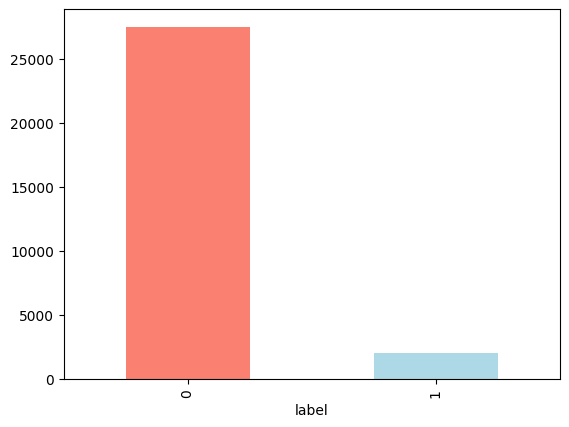

In [11]:
df1.label.value_counts().plot(kind="bar", color=["salmon", "lightblue"]);

### **Loading the raw datase**

In [63]:
raw_data = pd.read_csv("raw_data.csv")
raw_data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [64]:
raw_data.columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')

In [65]:
raw_data = raw_data.drop(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither'], axis=1)
raw_data.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [66]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   24783 non-null  int64 
 1   tweet   24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB


In [67]:
# check for null values
raw_data.isnull().sum()

class    0
tweet    0
dtype: int64

In [68]:
# check if any tweet bodies are null
raw_data['tweet'].isnull().values.any()

False

In [69]:
# check if there are empty tweet
(df1.tweet.str.len() == 0).any()

False

In [70]:
# check for duplicate
raw_data.duplicated().sum()

0

In [71]:
# Let's check for the unique values in the dataset
raw_data['class'].unique()

array([2, 1, 0], dtype=int64)

<Axes: xlabel='class', ylabel='count'>

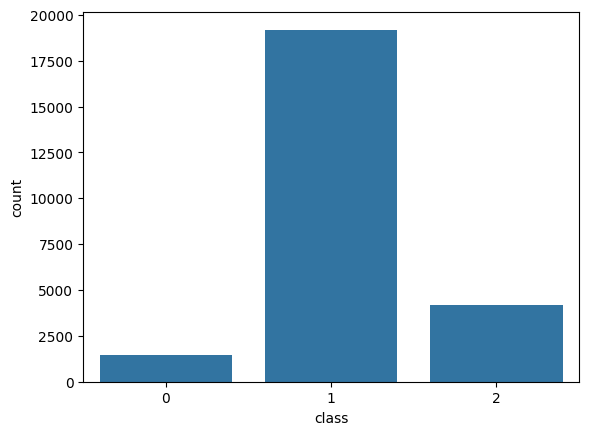

In [72]:
# Plotting the countplot for our new dataset
sns.countplot(x='class',data =raw_data)

- class 0: hate
- class 1: abusive
- class 2: no hate

In [73]:
# Let's copy the valus of the class 1 into class 0.
class_1_values = raw_data[raw_data['class'] == 1]['class'].values
class_0_indices = raw_data[raw_data['class'] == 0].index
raw_data.loc[class_0_indices, 'class'] = class_1_values[:len(class_0_indices)]


In [74]:
raw_data["class"].unique()

array([2, 1], dtype=int64)

In [75]:
raw_data['class'].value_counts()

class
1    20620
2     4163
Name: count, dtype: int64

<Axes: xlabel='class', ylabel='count'>

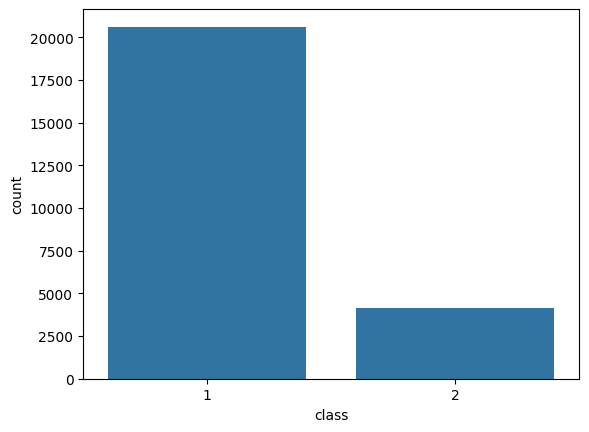

In [76]:
sns.countplot(x="class",data= raw_data)

In [77]:
# Let's replace the value of 2 to 0.
raw_data.replace({'class':{2:0}}, inplace=True)

<Axes: xlabel='class', ylabel='count'>

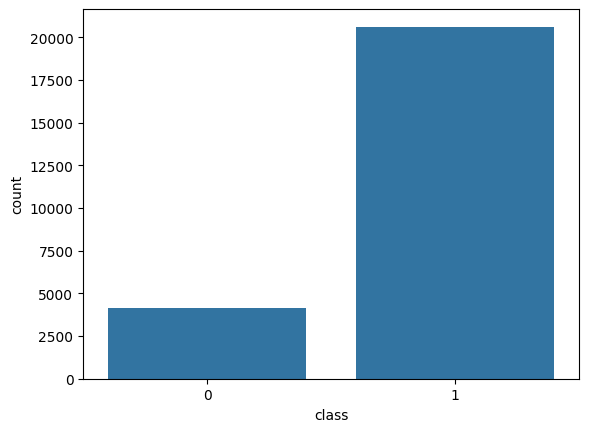

In [78]:
sns.countplot(x='class',data=raw_data)

In [79]:
df1.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [80]:
raw_data.head()

,class,tweet
0,0,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [81]:
# Let's change the name of the 'class' to label
raw_data.rename(columns={'class':'label'},inplace =True)

In [82]:
# Let's concatinate both the data into a single data frame.
frame = [df1, raw_data]
df = pd.concat(frame)
df.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54313 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   54313 non-null  int64 
 1   tweet   54313 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.2+ MB


<Axes: xlabel='label', ylabel='count'>

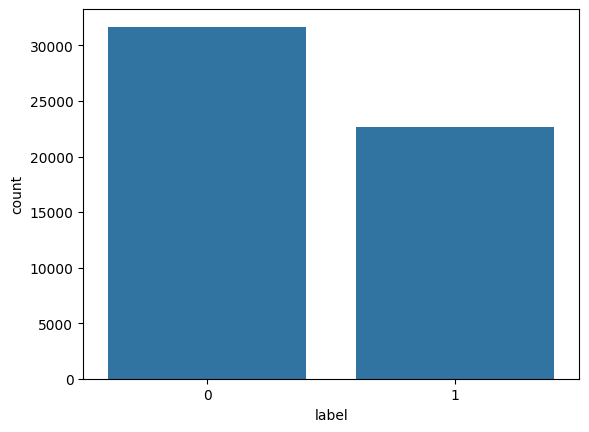

In [84]:
sns.countplot(x='label',data=df)

In [85]:
df.label.value_counts()

label
0    31680
1    22633
Name: count, dtype: int64

## Text Preprocessing
- Converting to lower case
- Tokenising
- Removing stop words
- Words stemming
- Removing punctuation
- Stripping out html tags

In [86]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\44787\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\44787\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [87]:
# Let's apply regex and do cleaning.
def data_cleaning(txt, stemmer=SnowballStemmer("english"), stop_words=set(stopwords.words('english'))):

    # remove html tags
    soup = BeautifulSoup(txt, 'html.parser')
    clean_text = soup.get_text()

    # convert to lower case and splits up the words
    words = word_tokenize(clean_text.lower())

    filter_words = []

    for word in words:
        # removing the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filter_words.append(stemmer.stem(word)) # words stemming

    return ' '.join(filter_words)

In [88]:
df["tweet"][1]

1    @user @user thanks for #lyft credit i can't us...
1    !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
Name: tweet, dtype: object

In [89]:
# let's apply the data_cleaning on the data.
df['tweet']=df['tweet'].apply(data_cleaning)

C:\Users\44787\AppData\Local\Temp\ipykernel_21892\3048935797.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(txt, 'html.parser')


In [90]:
df["tweet"][1]

1    user user thank lyft credit ca use caus offer ...
1    rt boy dat cold tyga dwn bad cuffin dat hoe place
Name: tweet, dtype: object

In [48]:
x = df['tweet']
y = df['label']

In [49]:
# Let's split the data into train and test
x_train,x_test,y_train,y_test = train_test_split(x,y, random_state = 42)

x_train.shape, x_test.shape

((40734,), (13579,))

## Model Section

### **Model 0:** Naive Bayes (baseline)

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(x_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [46]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [47]:
y_pred = model_0.predict(x_test)

In [48]:
model_0_res = calculate_results(y_test, y_pred)
model_0_res

{'accuracy': 91.7446056410634,
 'precision': 0.9173334697693812,
 'recall': 0.917446056410634,
 'f1': 0.9173071891410431}

### **Model 1:** A simple dense model

In [49]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

In [50]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [51]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(x_train)

In [52]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1")

embedding

In [53]:
# Build model with the Functional API
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [54]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [55]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [56]:
# Fit the model
model_1_history = model_1.fit(x_train, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              y_train,
                              epochs=5,
                              validation_data=(x_test, y_test))

Epoch 1/5
1273/1273 [==============================] - 19s 12ms/step - loss: 0.2881 - accuracy: 0.8959 - val_loss: 0.1707 - val_accuracy: 0.9401
Epoch 2/5
1273/1273 [==============================] - 8s 6ms/step - loss: 0.1392 - accuracy: 0.9515 - val_loss: 0.1552 - val_accuracy: 0.9486
Epoch 3/5
1273/1273 [==============================] - 7s 6ms/step - loss: 0.1134 - accuracy: 0.9612 - val_loss: 0.1592 - val_accuracy: 0.9480
Epoch 4/5
1273/1273 [==============================] - 7s 6ms/step - loss: 0.0990 - accuracy: 0.9667 - val_loss: 0.1698 - val_accuracy: 0.9458
Epoch 5/5
1273/1273 [==============================] - 7s 6ms/step - loss: 0.0892 - accuracy: 0.9704 - val_loss: 0.1786 - val_accuracy: 0.9447


In [57]:
# Check the results
model_1.evaluate(x_test, y_test)

425/425 [==============================] - 1s 3ms/step - loss: 0.1786 - accuracy: 0.9447


[0.17864859104156494, 0.9446940422058105]

In [58]:
y_pred = model_1.predict(x_test)

425/425 [==============================] - 1s 2ms/step


In [59]:
y_test

24283    0
31913    0
4735     1
4321     0
8045     1
        ..
3230     0
14352    0
20115    0
1769     1
16006    0
Name: label, Length: 13579, dtype: int64

In [60]:
tf.round(y_pred)

<tf.Tensor: shape=(13579, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [1.],
       ...,
       [0.],
       [1.],
       [0.]], dtype=float32)>

In [61]:
model_1_res = calculate_results(y_test,tf.round(y_pred))
model_1_res

{'accuracy': 94.46940128139039,
 'precision': 0.9447695021916469,
 'recall': 0.9446940128139039,
 'f1': 0.9445582032658203}

### **Model 2**: LSTM

**Note:** The reason we use a new embedding layer for each model is since the embedding layer is a learned representation of words (as numbers), if we were to use the same embedding layer for each model, we'd be mixing what one model learned with the next.

In [62]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [63]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 15, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                      

In [64]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


# Fit model
model_2_history = model_2.fit(x_train,
                              y_train,
                              epochs=5,
                              validation_data=(x_test, y_test))

Epoch 1/5
1273/1273 [==============================] - 28s 18ms/step - loss: 0.1896 - accuracy: 0.9291 - val_loss: 0.1549 - val_accuracy: 0.9463
Epoch 2/5
1273/1273 [==============================] - 14s 11ms/step - loss: 0.1191 - accuracy: 0.9579 - val_loss: 0.1504 - val_accuracy: 0.9475
Epoch 3/5
1273/1273 [==============================] - 13s 10ms/step - loss: 0.0900 - accuracy: 0.9688 - val_loss: 0.1727 - val_accuracy: 0.9417
Epoch 4/5
1273/1273 [==============================] - 19s 15ms/step - loss: 0.0655 - accuracy: 0.9768 - val_loss: 0.2026 - val_accuracy: 0.9376
Epoch 5/5
1273/1273 [==============================] - 14s 11ms/step - loss: 0.0493 - accuracy: 0.9825 - val_loss: 0.2312 - val_accuracy: 0.9392


In [65]:
model_2.evaluate(x_test, y_test)

425/425 [==============================] - 2s 5ms/step - loss: 0.2312 - accuracy: 0.9392


[0.23121210932731628, 0.939170777797699]

In [66]:
y_pred2 = model_2.predict(x_test)

425/425 [==============================] - 2s 3ms/step


In [67]:
model_2_res = calculate_results(y_test,tf.round(y_pred2))
model_2_res

{'accuracy': 93.91707784078356,
 'precision': 0.9392517275614829,
 'recall': 0.9391707784078356,
 'f1': 0.939202067471359}

### **Model 3:** GRU

In [70]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
x = layers.GRU(64, return_sequences=True)(x) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x)
x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru_4 (GRU)                 (None, 15, 64)            37248     
                                                                 
 gru_5 (GRU)                 (None, 64)                24960     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                       

In [71]:
# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


# Fit model
model_3_history = model_3.fit(x_train,
                              y_train,
                              epochs=5,
                              validation_data=(x_test, y_test))

Epoch 1/5
1273/1273 [==============================] - 33s 23ms/step - loss: 0.1934 - accuracy: 0.9256 - val_loss: 0.1542 - val_accuracy: 0.9457
Epoch 2/5
1273/1273 [==============================] - 17s 13ms/step - loss: 0.1171 - accuracy: 0.9594 - val_loss: 0.1500 - val_accuracy: 0.9473
Epoch 3/5
1273/1273 [==============================] - 15s 12ms/step - loss: 0.0855 - accuracy: 0.9705 - val_loss: 0.1657 - val_accuracy: 0.9453
Epoch 4/5
1273/1273 [==============================] - 13s 10ms/step - loss: 0.0602 - accuracy: 0.9800 - val_loss: 0.1899 - val_accuracy: 0.9401
Epoch 5/5
1273/1273 [==============================] - 22s 17ms/step - loss: 0.0431 - accuracy: 0.9856 - val_loss: 0.2410 - val_accuracy: 0.9376


In [72]:
model_3.evaluate(x_test, y_test)

425/425 [==============================] - 2s 4ms/step - loss: 0.2410 - accuracy: 0.9376


[0.24097566306591034, 0.9375506043434143]

In [75]:
y_pred3 = model_3.predict(x_test)

425/425 [==============================] - 2s 5ms/step


In [76]:
model_3_res = calculate_results(y_test,tf.squeeze(tf.round(y_pred3)))
model_3_res

{'accuracy': 93.75506296487222,
 'precision': 0.9375818518285308,
 'recall': 0.9375506296487223,
 'f1': 0.9375645548855641}

### **Model 4:** Bidirectonal RNN model

In [77]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 15, 128)           98816     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                             

In [78]:
# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


# Fit the model (takes longer because of the bidirectional layers)
model_4_history = model_4.fit(x_train,
                              y_train,
                              epochs=5,
                              validation_data=(x_test, y_test))

Epoch 1/5
1273/1273 [==============================] - 55s 34ms/step - loss: 0.1878 - accuracy: 0.9306 - val_loss: 0.1523 - val_accuracy: 0.9468
Epoch 2/5
1273/1273 [==============================] - 24s 19ms/step - loss: 0.1170 - accuracy: 0.9582 - val_loss: 0.1501 - val_accuracy: 0.9479
Epoch 3/5
1273/1273 [==============================] - 17s 13ms/step - loss: 0.0826 - accuracy: 0.9698 - val_loss: 0.1688 - val_accuracy: 0.9445
Epoch 4/5
1273/1273 [==============================] - 17s 14ms/step - loss: 0.0551 - accuracy: 0.9803 - val_loss: 0.2024 - val_accuracy: 0.9395
Epoch 5/5
1273/1273 [==============================] - 21s 16ms/step - loss: 0.0399 - accuracy: 0.9853 - val_loss: 0.2559 - val_accuracy: 0.9384


In [79]:
model_4.evaluate(x_test, y_test)

425/425 [==============================] - 2s 5ms/step - loss: 0.2559 - accuracy: 0.9384


[0.2558801472187042, 0.938434362411499]

In [80]:
y_pred4 = model_4.predict(x_test)

425/425 [==============================] - 4s 5ms/step


In [81]:
model_4_res = calculate_results(y_test,tf.squeeze(tf.round(y_pred4)))
model_4_res

{'accuracy': 93.84343471536933,
 'precision': 0.93837706568767,
 'recall': 0.9384343471536932,
 'f1': 0.9383868875868856}

### **Model 5:** Conv1D

In [82]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Get a summary of our 1D convolution model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_5 (Dense)             (None, 1)              

In [83]:
# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


# Fit the model
model_5_history = model_5.fit(x_train,
                              y_train,
                              epochs=5,
                              validation_data=(x_test, y_test))

Epoch 1/5
1273/1273 [==============================] - 32s 22ms/step - loss: 0.1919 - accuracy: 0.9295 - val_loss: 0.1554 - val_accuracy: 0.9454
Epoch 2/5
1273/1273 [==============================] - 14s 11ms/step - loss: 0.1062 - accuracy: 0.9627 - val_loss: 0.1577 - val_accuracy: 0.9458
Epoch 3/5
1273/1273 [==============================] - 8s 6ms/step - loss: 0.0597 - accuracy: 0.9802 - val_loss: 0.1828 - val_accuracy: 0.9429
Epoch 4/5
1273/1273 [==============================] - 14s 11ms/step - loss: 0.0302 - accuracy: 0.9910 - val_loss: 0.2293 - val_accuracy: 0.9383
Epoch 5/5
1273/1273 [==============================] - 10s 8ms/step - loss: 0.0172 - accuracy: 0.9947 - val_loss: 0.2623 - val_accuracy: 0.9383


In [84]:
model_5.evaluate(x_test, y_test)

425/425 [==============================] - 1s 3ms/step - loss: 0.2623 - accuracy: 0.9383


[0.26225197315216064, 0.938287079334259]

In [85]:
y_pred5 = model_5.predict(x_test)

425/425 [==============================] - 1s 2ms/step


In [86]:
model_5_res = calculate_results(y_test,tf.squeeze(tf.round(y_pred5)))
model_5_res

{'accuracy': 93.82870609028647,
 'precision': 0.938226475395038,
 'recall': 0.9382870609028647,
 'f1': 0.9382296577090812}

### **Model 6:** TensorFlow Hub Pretrained Sentence Encoder

In [87]:
import tensorflow_hub as hub

# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

In [88]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [89]:
# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(x_train,
                              y_train,
                              epochs=5,
                              validation_data=(x_test, y_test))

Epoch 1/5
1273/1273 [==============================] - 38s 26ms/step - loss: 0.2657 - accuracy: 0.8981 - val_loss: 0.2329 - val_accuracy: 0.9097
Epoch 2/5
1273/1273 [==============================] - 31s 24ms/step - loss: 0.2267 - accuracy: 0.9097 - val_loss: 0.2216 - val_accuracy: 0.9132
Epoch 3/5
1273/1273 [==============================] - 25s 20ms/step - loss: 0.2157 - accuracy: 0.9155 - val_loss: 0.2143 - val_accuracy: 0.9165
Epoch 4/5
1273/1273 [==============================] - 19s 15ms/step - loss: 0.2072 - accuracy: 0.9187 - val_loss: 0.2111 - val_accuracy: 0.9180
Epoch 5/5
1273/1273 [==============================] - 18s 14ms/step - loss: 0.1988 - accuracy: 0.9230 - val_loss: 0.2076 - val_accuracy: 0.9189


In [90]:
model_6.evaluate(x_test, y_test)

425/425 [==============================] - 4s 9ms/step - loss: 0.2076 - accuracy: 0.9189


[0.20764204859733582, 0.9189189076423645]

In [91]:
y_pred6 = model_6.predict(x_test)

425/425 [==============================] - 5s 10ms/step


In [92]:
model_6_res = calculate_results(y_test,tf.squeeze(tf.round(y_pred6)))
model_6_res

{'accuracy': 91.8918918918919,
 'precision': 0.9188236875448581,
 'recall': 0.918918918918919,
 'f1': 0.9187573213937841}

### Combine all the above models

In [93]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": model_0_res,
                                  "simple_dense": model_1_res,
                                  "lstm": model_2_res,
                                  "gru": model_3_res,
                                  "bidirectional": model_4_res,
                                  "conv1d": model_5_res,
                                  "tf_hub_sentence_encoder": model_6_res})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,91.744606,0.917333,0.917446,0.917307
simple_dense,94.462037,0.944698,0.944620,0.944484
lstm,93.887621,0.938857,0.938876,0.938865
gru,93.755063,0.937582,0.937551,0.937565
bidirectional,93.843435,0.938377,0.938434,0.938387
conv1d,93.828706,0.938226,0.938287,0.938230
tf_hub_sentence_encoder,91.891892,0.918824,0.918919,0.918757


In [94]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

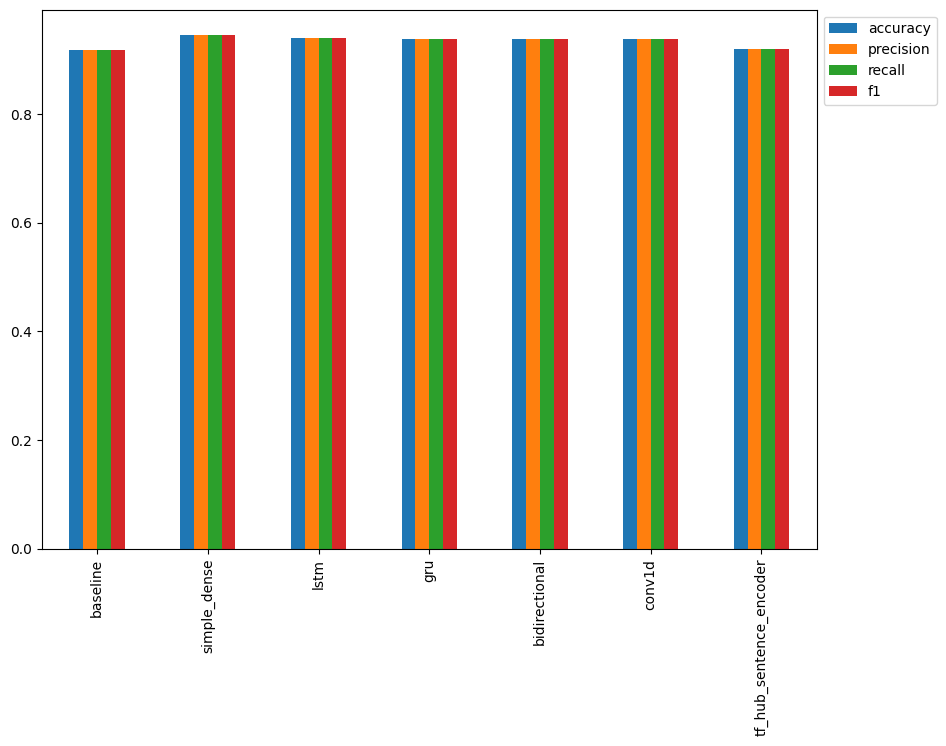

In [95]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

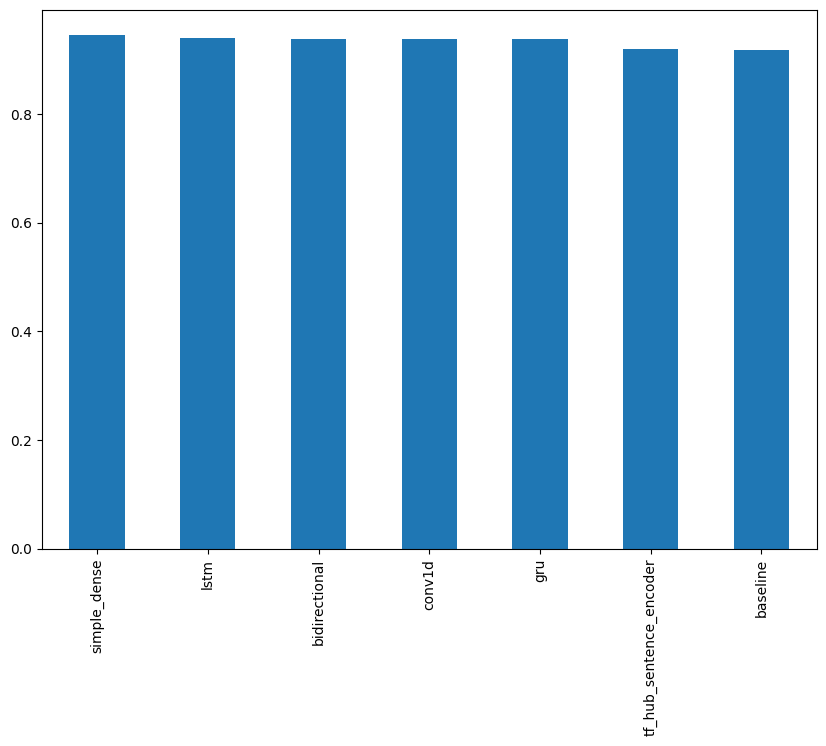

In [96]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

### **Model 7:** LSTM (Other way)

In [50]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

In [51]:
max_words = 50000
max_len = 300

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)

sequences = tokenizer.texts_to_sequences(x_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

In [52]:
sequences_matrix

array([[    0,     0,     0, ...,   328,   178,   399],
       [    0,     0,     0, ...,   918,     4,  2244],
       [    0,     0,     0, ...,   266,   606,  1430],
       ...,
       [    0,     0,     0, ...,  1193,   210,    49],
       [    0,     0,     0, ...,     1, 36806,  1210],
       [    0,     0,     0, ...,    40,   224,   127]])

In [100]:
# Creating model architecture.
model = Sequential()
model.add(Embedding(max_words,100,input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          5000000   
                                                                 
 spatial_dropout1d (Spatial  (None, 300, 100)          0         
 Dropout1D)                                                      
                                                                 
 lstm_4 (LSTM)               (None, 100)               80400     
                                                                 
 dense_8 (Dense)             (None, 1)                 101       
                                                                 
Total params: 5080501 (19.38 MB)
Trainable params: 5080501 (19.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [101]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

# starting model training
history = model.fit(sequences_matrix,
                    y_train,
                    batch_size=128,
                    epochs = 1,
                    validation_split=0.2)

255/255 [==============================] - 325s 1s/step - loss: 0.2963 - accuracy: 0.8822 - val_loss: 0.1775 - val_accuracy: 0.9363


In [102]:
test_sequences = tokenizer.texts_to_sequences(x_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

test_sequences_matrix

array([[    0,     0,     0, ...,   206,   176,   248],
       [    0,     0,     0, ...,     6,   205,  2421],
       [    0,     0,     0, ...,    51,     2, 12944],
       ...,
       [    0,     0,     0, ...,  2797,     1,    39],
       [    0,     0,     0, ...,    18,   110,     2],
       [    0,     0,     0, ..., 10909,   568,  1614]], dtype=int32)

In [103]:
# Model evaluation
model.evaluate(test_sequences_matrix,y_test)

425/425 [==============================] - 72s 170ms/step - loss: 0.1732 - accuracy: 0.9395


[0.173210009932518, 0.9395390152931213]

In [104]:
lstm_prediction = model.predict(test_sequences_matrix)

425/425 [==============================] - 40s 92ms/step


In [107]:
tf.round(lstm_prediction)

<tf.Tensor: shape=(13579, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [1.],
       ...,
       [0.],
       [1.],
       [0.]], dtype=float32)>

In [108]:
model_7_res = calculate_results(y_test, tf.round(lstm_prediction))
model_7_res

{'accuracy': 93.95389940349068,
 'precision': 0.9409810016568697,
 'recall': 0.9395389940349068,
 'f1': 0.9391115302187413}

In [109]:
res = []
for prediction in lstm_prediction:
    if prediction[0] < 0.5:
        res.append(0)
    else:
        res.append(1)

In [110]:
from sklearn.metrics import confusion_matrix

In [111]:
print(confusion_matrix(y_test,res))

[[7731  179]
 [ 642 5027]]


In [112]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [113]:
# Let's save the mdoel.
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Load the saved model and perform the prediction

In [114]:
import keras

In [115]:
load_model=keras.models.load_model("model.h5")
with open('tokenizer.pickle', 'rb') as handle:
    load_tokenizer = pickle.load(handle)

In [116]:
# Let's test our model on custom data.
test = 'i love this movie'

def text_cleaning(txt, stemmer=SnowballStemmer("english"), stop_words=set(stopwords.words('english'))):

    # remove html tags
    soup = BeautifulSoup(txt, 'html.parser')
    clean_text = soup.get_text()

    # convert to lower case and splits up the words
    words = word_tokenize(clean_text.lower())

    filter_words = []

    for word in words:
        # removing the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filter_words.append(stemmer.stem(word)) # words stemming

    return ' '.join(filter_words)

test=[text_cleaning(test)]
print(test)

seq = load_tokenizer.texts_to_sequences(test)
padded = pad_sequences(seq, maxlen=300)
print(seq)

pred = load_model.predict(padded)

print("pred", pred)
if pred<0.5:
    print("no hate")
else:
    print("hate and abusive")

['love movi']
[[6, 342]]
1/1 [==============================] - 1s 511ms/step
pred [[0.07272194]]
no hate
